<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Resize_in_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Learning to Resize in Computer Vision**

It is a common belief that if we constrain vision models to perceive things as humans do,
their performance can be improved. For example, in [this work](https://arxiv.org/abs/1811.12231),
Geirhos et al. showed that the vision models pre-trained on the ImageNet-1k dataset are
biased towards texture, whereas human beings mostly use the shape descriptor to develop a
common perception. But does this belief always apply, especially when it comes to improving
the performance of vision models?

It turns out it may not always be the case. When training vision models, it is common to
resize images to a lower dimension ((224 x 224), (299 x 299), etc.) to allow mini-batch
learning and also to keep up the compute limitations.  We generally make use of image
resizing methods like **bilinear interpolation** for this step and the resized images do
not lose much of their perceptual character to the human eyes. In
[Learning to Resize Images for Computer Vision Tasks](https://arxiv.org/abs/2103.09950v1), Talebi et al. show
that if we try to optimize the perceptual quality of the images for the vision models
rather than the human eyes, their performance can further be improved. They investigate
the following question:

**For a given image resolution and a model, how to best resize the given images?**

As shown in the paper, this idea helps to consistently improve the performance of the
common vision models (pre-trained on ImageNet-1k) like DenseNet-121, ResNet-50,
MobileNetV2, and EfficientNets. In this example, we will implement the learnable image
resizing module as proposed in the paper and demonstrate that on the
[Cats and Dogs dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765)
using the [DenseNet-121](https://arxiv.org/abs/1608.06993) architecture.

This example requires TensorFlow 2.4 or higher.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [2]:
INP_SIZE = (300, 300)
TARGET_SIZE = (150, 150)
INTERPOLATION = "bilinear"

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 5

In [3]:
train_ds, validation_ds = tfds.load(
    "cats_vs_dogs",
    split = ["train[:40%]", "train[40%:50%]"],
    as_supervised = True)


def preprocess_dataset(image, label):
    image = tf.image.resize(image, (INP_SIZE[0], INP_SIZE[1]))
    label = tf.one_hot(label, depth = 2)
    return (image, label)


train_ds = (train_ds.shuffle(BATCH_SIZE * 100)
            .map(preprocess_dataset, num_parallel_calls = AUTO)
            .batch(BATCH_SIZE)
            .prefetch(AUTO))

validation_ds = (validation_ds.map(preprocess_dataset, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

## Define the learnable resizer utilities

The figure below (courtesy: [Learning to Resize Images for Computer Vision Tasks](https://arxiv.org/abs/2103.09950v1))
presents the structure of the learnable resizing module:

![](https://i.ibb.co/gJYtSs0/image.png)

In [4]:
def conv_block(x, filters, kernel_size, strides, activation = layers.LeakyReLU(0.2)):
    x = layers.Conv2D(filters, kernel_size, strides, padding = "same", use_bias = False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    return x

def res_block(x):
    inputs = x
    x = conv_block(x, 16, 3, 1)
    x = conv_block(x, 16, 3, 1, activation = None)
    return layers.Add()([inputs, x])

#Note: user can change num_res_blocks to >1 also if needed
def get_learnable_resizer(filters=16, num_res_blocks=1, interpolation=INTERPOLATION):
    inputs = layers.Input(shape=[None, None, 3])

    # First, perform naive resizing.
    naive_resize = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation)(inputs)

    # First convolution block without batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=7, strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Second convolution block with batch normalization.
    x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    # Intermediate resizing as a bottleneck.
    bottleneck = layers.Resizing(
        *TARGET_SIZE, interpolation=interpolation)(x)

    # Residual passes.
    # First res_block will get bottleneck output as input
    x = res_block(bottleneck)
    # Remaining res_blocks will get previous res_block output as input
    for _ in range(num_res_blocks - 1):
        x = res_block(x)

    # Projection.
    x = layers.Conv2D(
        filters=filters, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Skip connection.
    x = layers.Add()([bottleneck, x])

    # Final resized image.
    x = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(x)
    final_resize = layers.Add()([naive_resize, x])

    return tf.keras.Model(inputs, final_resize, name="learnable_resizer")


learnable_resizer = get_learnable_resizer()

## Visualize the outputs of the learnable resizing module

Here, we visualize how the resized images would look like after being passed through the
random weights of the resizer.

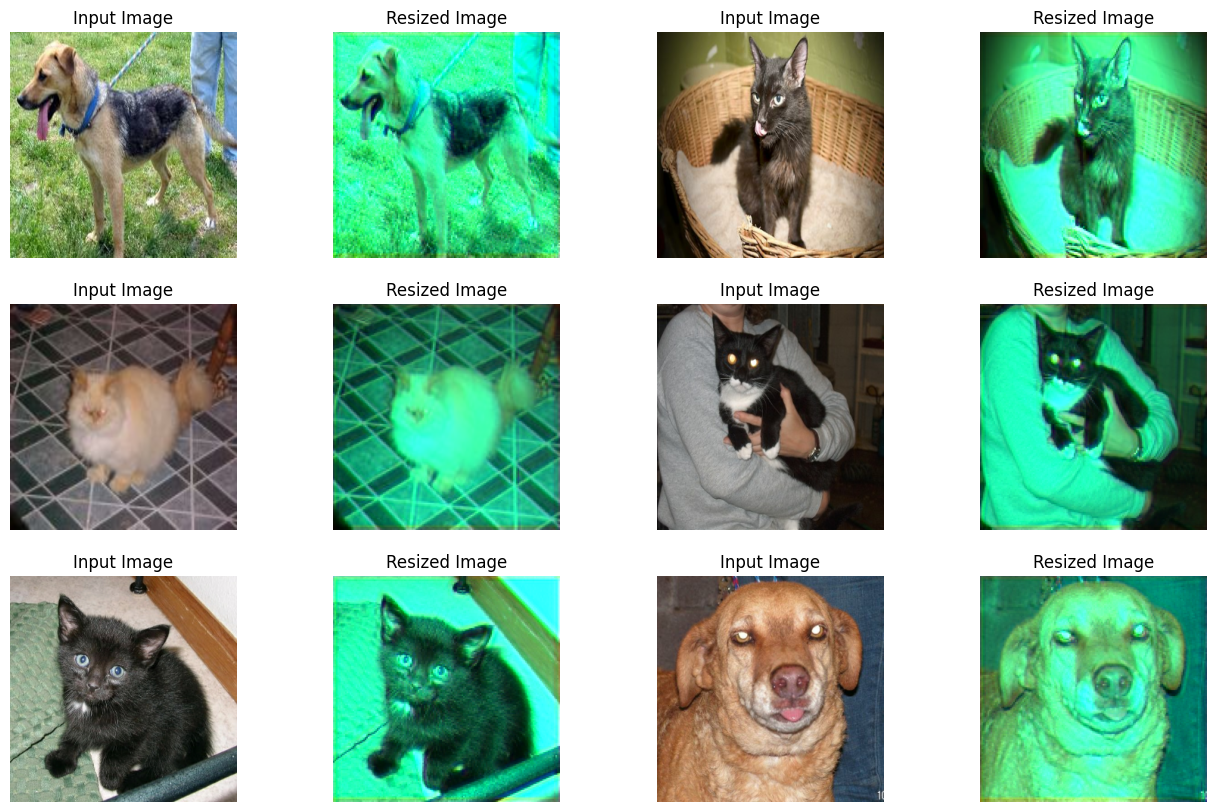

In [5]:
sample_images, _ = next(iter(train_ds))


plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze())
    plt.axis("off")

In [6]:
def get_model():
    backbone = keras.applications.DenseNet121(
                weights = None,
                include_top = True,
                input_shape = ((TARGET_SIZE[0], TARGET_SIZE[1], 3)),
                classes = 2)

    backbone.trainabel = True

    inputs = keras.Input((INP_SIZE[0], INP_SIZE[1], 3))
    x = layers.Rescaling(1./255.)(inputs)
    x = learnable_resizer(x)
    outputs = backbone(x)

    return keras.Model(inputs, outputs)

The structure of the learnable image resizer module allows for flexible integrations with
different vision models.



## Compile and train our model with learnable resizer

In [7]:
model = get_model()
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer="sgd",
    metrics=["accuracy"])
model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS)

Epoch 1/5
291/291 [==============================] - 150s 354ms/step - loss: 0.6866 - accuracy: 0.5783 - val_loss: 0.7481 - val_accuracy: 0.4987
Epoch 2/5
291/291 [==============================] - 96s 319ms/step - loss: 0.6587 - accuracy: 0.6225 - val_loss: 0.6684 - val_accuracy: 0.6118
Epoch 3/5
291/291 [==============================] - 96s 319ms/step - loss: 0.6430 - accuracy: 0.6515 - val_loss: 0.6810 - val_accuracy: 0.6410
Epoch 4/5
291/291 [==============================] - 99s 332ms/step - loss: 0.6146 - accuracy: 0.6844 - val_loss: 0.6881 - val_accuracy: 0.6414
Epoch 5/5
291/291 [==============================] - 99s 332ms/step - loss: 0.6013 - accuracy: 0.6978 - val_loss: 0.6716 - val_accuracy: 0.6066


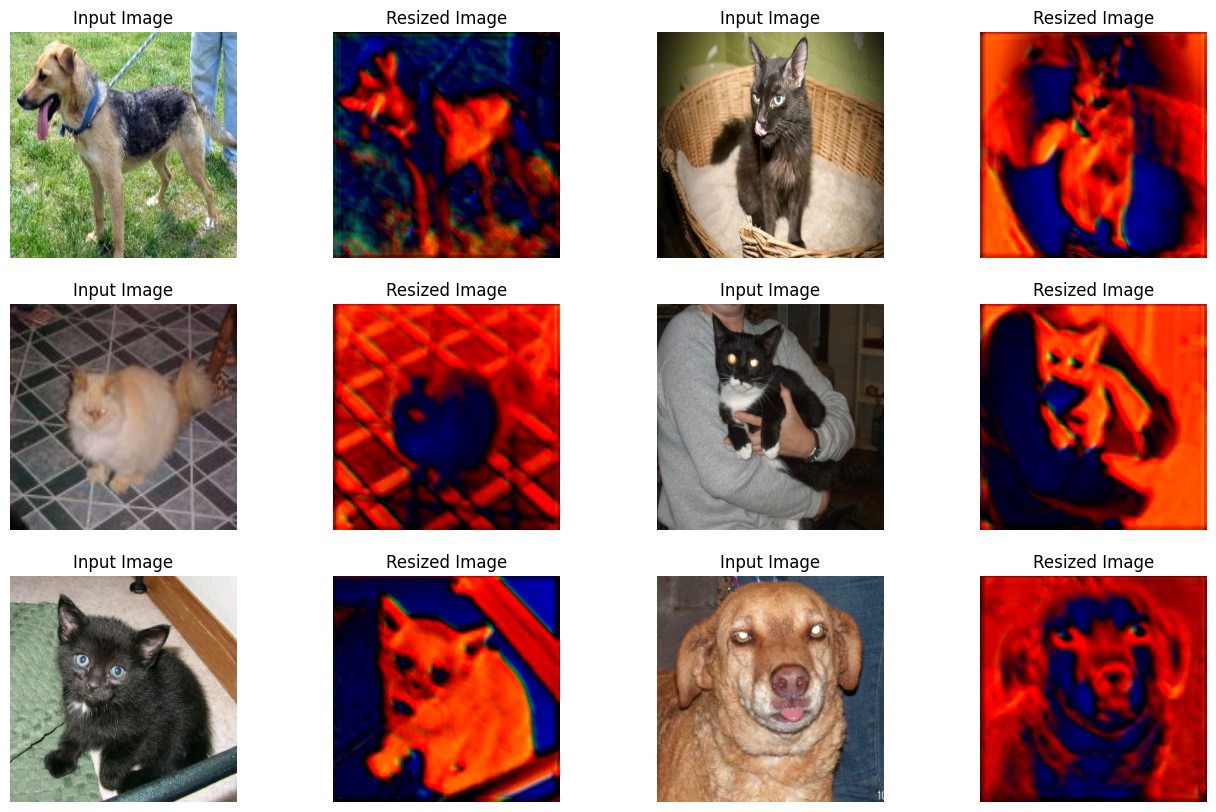

In [9]:
plt.figure(figsize=(16, 10))
for i, image in enumerate(sample_images[:6]):
    image = image / 255

    ax = plt.subplot(3, 4, 2 * i + 1)
    plt.title("Input Image")
    plt.imshow(image.numpy().squeeze())
    plt.axis("off")

    ax = plt.subplot(3, 4, 2 * i + 2)
    resized_image = learnable_resizer(image[None, ...])
    plt.title("Resized Image")
    plt.imshow(resized_image.numpy().squeeze() / 10)
    plt.axis("off")

The plot shows that the visuals of the images have improved with training. The following
table shows the benefits of using the resizing module in comparison to using the bilinear
interpolation:

|           Model               | Number of  parameters (Million)   | Top-1 accuracy    |
|:-------------------------:    |:-------------------------------:  |:--------------:   |
|   With the learnable resizer      |             7.051717              |      67.67%       |
| Without the learnable resizer     |             7.039554              |      60.19%       |

For more details, you can check out [this repository](https://github.com/sayakpaul/Learnable-Image-Resizing).
Note the above-reported models were trained for 10 epochs on 90% of the training set of
Cats and Dogs unlike this example. Also, note that the increase in the number of
parameters due to the resizing module is very negligible. To ensure that the improvement
in the performance is not due to stochasticity, the models were trained using the same
initial random weights.

Now, a question worth asking here is -  _isn't the improved accuracy simply a consequence
of adding more layers (the resizer is a mini network after all) to the model, compared to
the baseline?_

To show that it is not the case, the authors conduct the following experiment:

* Take a pre-trained model trained some size, say (224 x 224).

* Now, first, use it to infer predictions on images resized to a lower resolution. Record
the performance.

* For the second experiment, plug in the resizer module at the top of the pre-trained
model and warm-start the training. Record the performance.

Now, the authors argue that using the second option is better because it helps the model
learn how to adjust the representations better with respect to the given resolution.
Since the results purely are empirical, a few more experiments such as analyzing the
cross-channel interaction would have been even better. It is worth noting that elements
like [Squeeze and Excitation (SE) blocks](https://arxiv.org/abs/1709.01507), [Global Context (GC) blocks](https://arxiv.org/pdf/1904.11492) also add a few
parameters to an existing network but they are known to help a network process
information in systematic ways to improve the overall performance.



## Notes

* To impose shape bias inside the vision models, Geirhos et al. trained them with a
combination of natural and stylized images. It might be interesting to investigate if
this learnable resizing module could achieve something similar as the outputs seem to
discard the texture information.

* The resizer module can handle arbitrary resolutions and aspect ratios which is very
important for tasks like object detection and segmentation.

* There is another closely related topic on ***adaptive image resizing*** that attempts
to resize images/feature maps adaptively during training. [EfficientV2](https://arxiv.org/pdf/2104.00298)
uses this idea.